# Acquisition and Prep For Regression

In [1]:
# Imports for data manipulation and exploration
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from env import get_db_url
import os
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None

In [2]:
def get_zillow_data(use_cache=True):
    '''
    Function to collect zillow data. Checks for copy and if 
    not present then pulls from mySQL
    '''
    
    # Assign filename
    filename = 'zillow.csv'
    
    # Check if file exists
    if os.path.exists(filename) and use_cache:
        print('Using cached csv file...')
        return pd.read_csv(filename)
    
    # Notify user of next step
    print('Getting a fresh copy from the database...')
    
    # Assign url
    url = get_db_url('zillow')
    
    # Run query for data
    zillow_data = pd.read_sql('''
    SELECT bedroomcnt,\
    bathroomcnt,\
    calculatedfinishedsquarefeet as finishedsquareft,\
    taxvaluedollarcnt,\
    yearbuilt,\
    taxamount,\
    fips
    FROM properties_2017
    LEFT JOIN propertylandusetype
    USING(propertylandusetypeid)
    WHERE propertylandusetypeid = 261 OR propertylandusetypeid = 279
    ''', url)
    
    # Notify user of next step
    print('Saving to csv...')
    
    # Create csv
    zillow_data.to_csv(filename, index=False)
    
    # Return DataFrame
    return zillow_data

In [3]:
# Collect and store data in csv and dataframe
zillow = get_zillow_data()
# zillow.head()

Using cached csv file...


In [31]:
# explore size of df 
# zillow.shape

7 columns with 2,152,864 rows

In [32]:
# Summary Statistics for data. 
# zillow.describe().T

Counts are not consistent.

In [33]:
# Explore datatypes of each variable. 
# zillow.info()

Everything is a float.

#### Acquire and Summarize Takeaways

Counts do not seem consistent. Lots of NaN values. Lots of zero values. Looking at the jump in quartiles there could be possible outliers on the high end.


### Explore Nulls and variable structure

In [34]:
# Explore nulls in values
# zillow.isnull().sum()

Nulls makeup a small percentage of total values. Dropping them seems acceptable. Will explore more.

In [35]:
# Bedroom value counts
# zillow.bedroomcnt.value_counts(dropna=False, ascending=True)

Looks like most houses have 0 to 6 rooms. Only 11 nulls

In [36]:
# Null bedroom values
# zillow[zillow.bedroomcnt.isnull()]

Where bedroomcnt is null bathroomcnt is null also missing most square feet, tax amount and some year built

In [37]:
# Bathroom value counts
# zillow.bathroomcnt.value_counts(dropna=False, ascending=True)

11 nulls, most houses have 0 to 6 bathrooms

In [38]:
# Null bathroom values
# zillow[zillow.bathroomcnt.isnull()]

Same data as bedroomcnt

In [39]:
# finished sqaure feet counts
# zillow.finishedsquareft.value_counts(dropna=False, ascending = False)

Mostly unique values. over 8000 nulls

In [40]:
# Null finishedsquareft values
# zillow[zillow.finishedsquareft.isnull()]

Most nulls are missing a majority of the data

In [41]:
# tax value dollar count counts
# zillow.taxvaluedollarcnt.value_counts(dropna=False, ascending = True)

Unique values. 

In [42]:
# Null taxvaluedollarcnt values
# zillow[zillow.taxvaluedollarcnt.isnull()]

Most null are missing a majority of the data

In [43]:
# Year built value counts
# zillow.yearbuilt.value_counts(dropna=False, ascending = True)

Houses range in year built. Starting in the 1800's. A good amount were built in the 1950's. Over 9000 nulls.

In [44]:
# Null year built values
# zillow[zillow.yearbuilt.isnull()]

Missing most of the data

In [45]:
# Tax amount counts
# zillow.taxamount.value_counts(dropna=False, ascending = False)

Mostly unique, 4000 nulls

In [46]:
# Null tax amount values
# zillow[zillow.taxamount.isnull()]

More data than most but still missing a lot and only makes up a small percentage of overall data.

In [47]:
# fips value counts
# zillow.fips.value_counts(dropna=False, ascending = True)

3 values. Exploring fips it looks to be a county identifier.
- 6111: Ventura, Ca, 
- 6059: Orange, Ca, 
- 6037: Los Angeles, Ca 

change the data type to a string and one hot encode 

#### Takeaways from exploring nulls and variables

I should be able to drop nulls and rename fips as county. Then assign the county names and one hot encode for later analysis.

### Prep Data

In [12]:
# Drop nulls
zillow = zillow.dropna()

In [13]:
# check for nulls
# zillow.isnull().sum()

In [14]:
# Rename columns
zillow = zillow.rename(columns={'bedroomcnt' : 'bedrooms',\
                                'bathroomcnt' : 'bathrooms',\
                                'finishedsquareft' : 'area',\
                                'taxvaluedollarcnt' : 'taxable_value',\
                                'yearbuilt' : 'year_built',\
                                'taxamount' : 'tax_amount',\
                                'fips' : 'county'})

In [16]:
# Map county values to name of county
zillow.county = zillow.county.map({6037.0 : 'los_angeles_ca',\
                                   6059.0 : 'orange_ca',\
                                   6111.0 : 'ventura_ca'})

In [6]:
# One hot encode county 

# Get dummy variables
dummy_name = pd.get_dummies(zillow[['county']])

# Concat dummy_name to dataframe
zillow = pd.concat([zillow,dummy_name],axis=1)

# zillow.head()

### Create wrangle function

In [4]:
def wrangle_zillow():
    '''
    function used to wrangle zillow data
    '''
    
    # Rename columns
    zillow = zillow.rename(columns={'bedroomcnt' : 'bedrooms',\
                                    'bathroomcnt' : 'bathrooms',\
                                    'finishedsquareft' : 'area',\
                                    'taxvaluedollarcnt' : 'taxable_value',\
                                    'yearbuilt' : 'year_built',\
                                    'taxamount' : 'tax_amount',\
                                    'fips' : 'county'})
    
    # Drop nulls
    zillow = get_zillow_data()
    
    # Rename fips to county
    zillow = zillow.dropna()
    
    # Map county values to name of county
    zillow.county = zillow.county.map({6037.0 : 'los_angeles_ca',\
                                       6059.0 : 'orange_ca',\
                                       6111.0 : 'ventura_ca'})
    
    
    # One hot encode county 

    # Get dummy variables
    dummy_name = pd.get_dummies(zillow[['county']])

    # Concat dummy_name to dataframe
    zillow = pd.concat([zillow,dummy_name],axis=1)
    
    return zillow

### Visualize Distributions

In [35]:
# Visualize each variable with a displot
# for col in zillow.columns[zillow.dtypes == 'float']:
#     sns.displot(zillow[col],bins = 10)
#     plt.title(col)
#     plt.show()

Nothing really to note

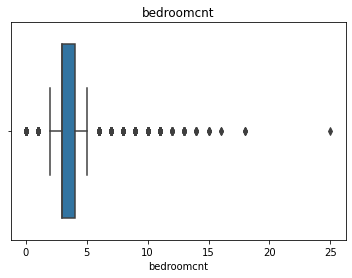

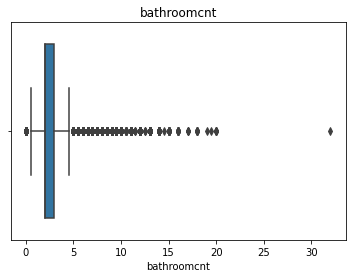

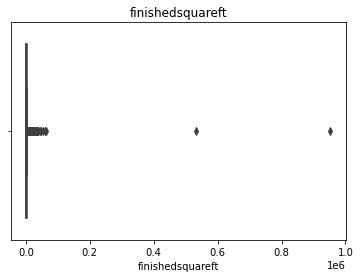

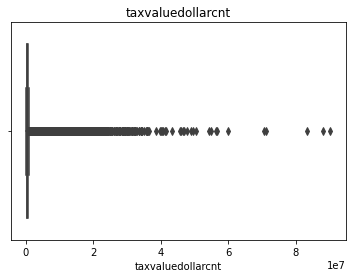

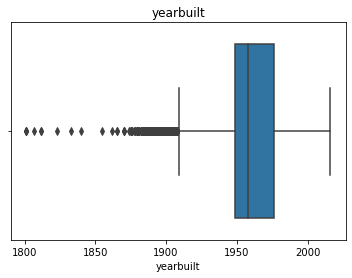

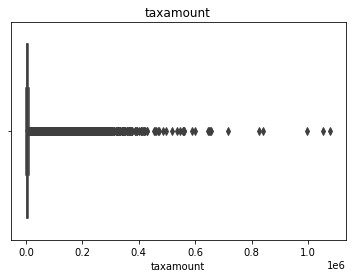

In [8]:
# Box plot for float data. 
for col in zillow.columns[zillow.dtypes == 'float']:
    sns.boxplot(x = col, data = zillow)
    plt.title(col)
    plt.show()

Looks to be a lot of outliers

In [59]:
# Count for counties
# sns.countplot(data=zillow,x='county')
# plt.show()

In [60]:
# County value counts
# zillow.county.value_counts()

- LA: 1,425,207 
- Orange: 552,057
- Ventura: 162,971

In [5]:
zillow = wrangle_zillow()
zillow.head()

Using cached csv file...


,bedroomcnt,bathroomcnt,finishedsquareft,taxvaluedollarcnt,yearbuilt,taxamount,county,county_los_angeles_ca,county_orange_ca,county_ventura_ca
4,4.0,2.0,3633.0,296425.0,2005.0,6941.39,los_angeles_ca,1,0,0
6,3.0,4.0,1620.0,847770.0,2011.0,10244.94,los_angeles_ca,1,0,0
7,3.0,2.0,2077.0,646760.0,1926.0,7924.68,los_angeles_ca,1,0,0
11,0.0,0.0,1200.0,5328.0,1972.0,91.60,los_angeles_ca,1,0,0
14,0.0,0.0,171.0,6920.0,1973.0,255.17,los_angeles_ca,1,0,0
